In [129]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from pytz import timezone

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras import optimizers
import keras
import talib
from fractions import gcd
import time

import pywt
from statsmodels.robust import stand_mad

def get_CU():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu")
    return X

def get_SP500():
    import pandas_datareader as pdr    
    SP500 = pdr.get_data_yahoo('^GSPC')
    return SP500

def get_X_data():
    import dovahkiin as dk
    dp = dk.DataParser()
    X = dp.get_data("cu", split_threshold="1D")
    return X

X = get_X_data()

In [9]:
fig_size = (12, 9)
plt.rcParams["figure.figsize"] = fig_size
X["HLC"] = (X.high + X.low + X.close) / 3
X["return"] = X.HLC.pct_change()
X["return"] = X["return"].fillna(0)

In [3]:
time_series_step=4

def timeseries_to_supervised(raw_time_series, lag):
    p = {}
    for i in range(1, lag+1):
        p["{}".format(i)] = raw_time_series.shift(i).fillna(0)
    p["0"] = raw_time_series
    
    supervised_data = pd.Panel(p)
    return supervised_data

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

def create_supervised_X(raw_time_series, lag):
    supervised_X = timeseries_to_supervised(raw_time_series, lag)
    swaped_supervised_X = supervised_X.swapaxes(0, 1)
    return swaped_supervised_X

In [4]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []


    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

Test: 28.89%
Train: 71.11%


In [72]:
#Divide Data into Train and Test
X_train = X[:"2015"]
X_test = X["2016":]
print("Test: {:.2f}%".format(100 * len(X_test)/len(X["2012":])))
print("Train: {:.2f}%".format(100 * len(X_train)/len(X["2012":])))


y = X["return"].shift(-1)
y = y.fillna(0)
y_train = y["2012":"2015"]
y_test  = y["2016":]

del X_train['HLC']
del X_train['open']
del X_train['high'] 
del X_train['low']
del X_train['close']
del X_train['volume']
del X_train['openint']

del X_test["HLC"]
del X_test['open']
del X_test['high'] 
del X_test['low']
del X_test['close']
del X_test['volume']
del X_test['openint']


scaler = StandardScaler()
y_scaler = StandardScaler()

X_train["return_scaled"] = scaler.fit_transform(pd.DataFrame(X_train["return"].values))
X_test["return_scaled"] = scaler.transform(pd.DataFrame(X_test["return"].values))
X_train = create_supervised_X(pd.DataFrame(X_train["return_scaled"]), time_series_step)
X_test  = create_supervised_X(pd.DataFrame(X_test["return_scaled"]), time_series_step)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

batch_size = gcd(len(X_train), len(X_test))
features = 1

model = Sequential()
model.add(
    LSTM(128, batch_input_shape=(batch_size, time_series_step+1, features), 
         return_sequences=True, 
         activation="relu",
         kernel_regularizer='l1',
          recurrent_regularizer='l1',
          bias_regularizer='l1',
          dropout=0.1,
          recurrent_dropout=0.1
        )
)

model.add(
    LSTM(128, 
         return_sequences=True, 
         activation="relu",
         kernel_regularizer='l1',
          recurrent_regularizer='l1',
          bias_regularizer='l1',
          dropout=0.1,
          recurrent_dropout=0.1
        )
)
    
model.add(
    LSTM(32, 
         activation="relu", 
         return_sequences=True,
         kernel_regularizer='l1',
         recurrent_regularizer='l1',
         bias_regularizer='l1',
         dropout=0.1,
         recurrent_dropout=0.1)
)

model.add(LSTM(1))

model.compile(loss="mse", optimizer="adadelta")

Test: 28.89%
Train: 207.64%


In [37]:
history = LossHistory()
model.fit(X_train.values, 
          y_train, 
          epochs=2, 
          batch_size=batch_size, 
          shuffle=False, 
          validation_data=(X_test.values, y_test),
          callbacks=[history]
)

Train on 1061 samples, validate on 431 samples
Epoch 1/2
1061/1061 [==============================] - 49s - loss: 9.5717 - val_loss: 2.8763
Epoch 2/2
1061/1061 [==============================] - 45s - loss: 2.2080 - val_loss: 2.3921


In [29]:
model.reset_states()

In [38]:
model.predict(X_train.values, batch_size=1)

array([[ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       ..., 
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469]], dtype=float32)

In [39]:
y_test_predict = model.predict(X_test.values, batch_size=1)

In [40]:
y_test_predict

array([[ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0.00106469],
       [ 0

### LSTM model without state

In [41]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [123]:
def load_data(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = len(X_train)
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [136]:
epochs  = 10
seq_len = 50

print('> Loading data... ')
x_train, y_train, x_test, y_test = load_data(X.close.values, 50, True)

> Loading data... 


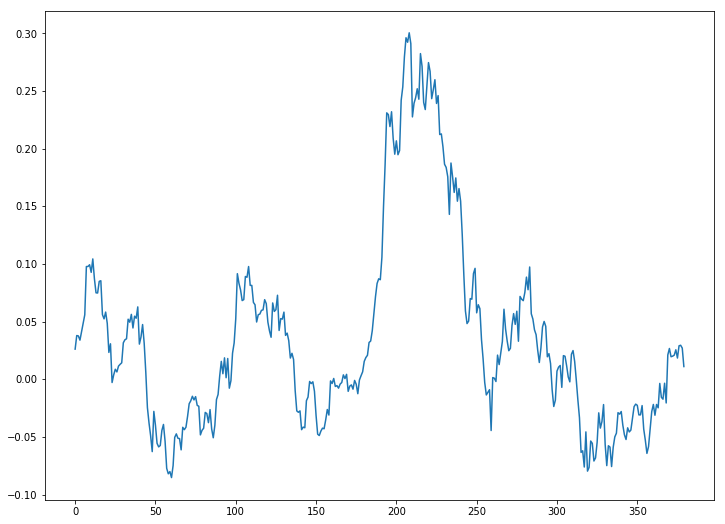

In [133]:
plt.clf()
plt.plot(y_test)
plt.show()

In [138]:
print('> Data Loaded. Compiling...')
model = build_model([1, 50, 100, 1])

model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05)

predicted = predict_point_by_point(model, x_test)

> Data Loaded. Compiling...
> Compilation Time :  0.02333688735961914
Train on 2943 samples, validate on 155 samples
Epoch 1/10
2943/2943 [==============================] - 8s - loss: 0.0087 - val_loss: 0.0023
Epoch 2/10
2943/2943 [==============================] - 5s - loss: 0.0022 - val_loss: 0.0021
Epoch 3/10
2943/2943 [==============================] - 4s - loss: 0.0021 - val_loss: 0.0019
Epoch 4/10
2943/2943 [==============================] - 4s - loss: 0.0018 - val_loss: 0.0020
Epoch 5/10
2943/2943 [==============================] - 4s - loss: 0.0020 - val_loss: 0.0015
Epoch 6/10
2943/2943 [==============================] - 4s - loss: 0.0017 - val_loss: 0.0016
Epoch 7/10
2943/2943 [==============================] - 4s - loss: 0.0016 - val_loss: 0.0020
Epoch 8/10
2943/2943 [==============================] - 4s - loss: 0.0015 - val_loss: 0.0012
Epoch 9/10
2943/2943 [==============================] - 4s - loss: 0.0012 - val_loss: 0.0015
Epoch 10/10
2943/2943 [=======================

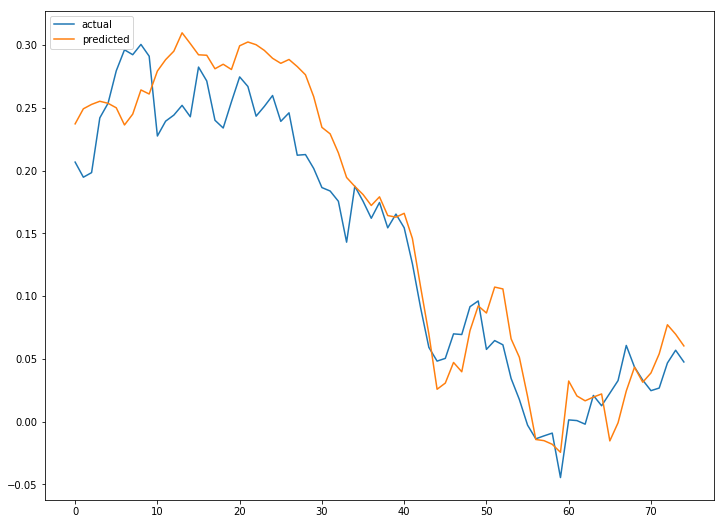

In [143]:
plt.clf()
plt.plot(y_test[200:275])
plt.plot(predicted[200:275])
plt.legend(["actual", "predicted"], loc='upper left')
plt.show()